# Preparation of the hierarchical negative binomial model

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
from pathlib import Path
from time import time

import arviz as az
import matplotlib.pyplot as plt
import nest_asyncio
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns

In [3]:
from speclet.bayesian_models.hierarchical_nb import HierarchcalNegativeBinomialModel
from speclet.io import DataFile, models_dir
from speclet.managers.cache_manager import PosteriorManager
from speclet.managers.data_managers import CrisprScreenDataManager
from speclet.modeling.model_fitting_api import fit_pymc3_mcmc, fit_stan_mcmc
from speclet.plot.plotnine_helpers import set_gg_theme
from speclet.project_configuration import read_project_configuration
from speclet.project_enums import ModelFitMethod

In [4]:
notebook_tic = time()

# Configuration for plotting libraries.
set_gg_theme()
%config InlineBackend.figure_format = "retina"

# Scalar constants.
RANDOM_SEED = 847
np.random.seed(RANDOM_SEED)
HDI_PROB = read_project_configuration().modeling.highest_density_interval

## Data

In [5]:
data_manager = CrisprScreenDataManager(DataFile.DEPMAP_CRC_SUBSAMPLE)
counts_data = data_manager.get_data()
counts_data.head()

sgrna                  replicate_id       lfc  \
0   ACGCCACTGACACTCAAGG                  LS513_c903R1  0.583209   
1  AGCTGAGCGCAGGGACCGGG  LS513-311Cas9_RepA_p6_batch2 -0.020788   
2  CTACTAGACTTCCTGCCGGC  LS513-311Cas9_RepA_p6_batch2 -0.666070   
3  AAACTTGCTGACGTGCCTGG  LS513-311Cas9_RepA_p6_batch2 -0.130231   
4   AACAACTAACTTTGTACAT                  LS513_c903R1  0.226828   

         p_dna_batch genome_alignment hugo_symbol  screen  \
0  ERS717283.plasmid  chr1_27006713_-      TENT5B  sanger   
1                  2  chr1_27012633_-      TENT5B   broad   
2                  2  chr1_27006754_-      TENT5B   broad   
3                  2  chr4_52628042_-       USP46   broad   
4  ERS717283.plasmid  chr8_81679130_-       IMPA1  sanger   

   multiple_hits_on_gene sgrna_target_chr  sgrna_target_pos  ...  \
0                   True                1          27006713  ...   
1                   True                1          27012633  ...   
2                   True                1          27006754  ...   
3                   True                4          52628042  ...   
4                   True                8          81679130  ...   

  num_mutations  any_deleterious  any_tcga_hotspot  any_cosmic_hotspot  \
0             0              NaN               NaN                 NaN   
1             0              NaN               NaN                 NaN   
2             0              NaN               NaN                 NaN   
3             0              NaN               NaN                 NaN   
4             0              NaN               NaN                 NaN   

   is_mutated copy_number     lineage primary_or_metastasis  is_male   age  
0       False    0.961139  colorectal               primary     True  63.0  
1       False    0.961139  colorectal               primary     True  63.0  
2       False    0.961139  colorectal               primary     True  63.0  
3       False    0.952543  colorectal               primary     True  63.0  
4       False    0.957015  colorectal               primary     True  63.0  

[5 rows x 24 columns]

## Posterior sampling

In [6]:
speclet_hiernb = HierarchcalNegativeBinomialModel()

### Stan MCMC

In [7]:
stan_trace_pm = PosteriorManager("hierarchical-nb_STAN_MCMC", models_dir())

In [8]:
assert stan_trace_pm.posterior_cache_exists, "Stan MCMC cache not found."
stan_trace = stan_trace_pm.get()
stan_trace

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [9]:
az_var_names = speclet_hiernb.vars_regex(ModelFitMethod.PYMC3_MCMC)

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/arviz/utils.py:129: UserWarning: Items starting with ~: ['^eta$'] have not been found and will be ignored


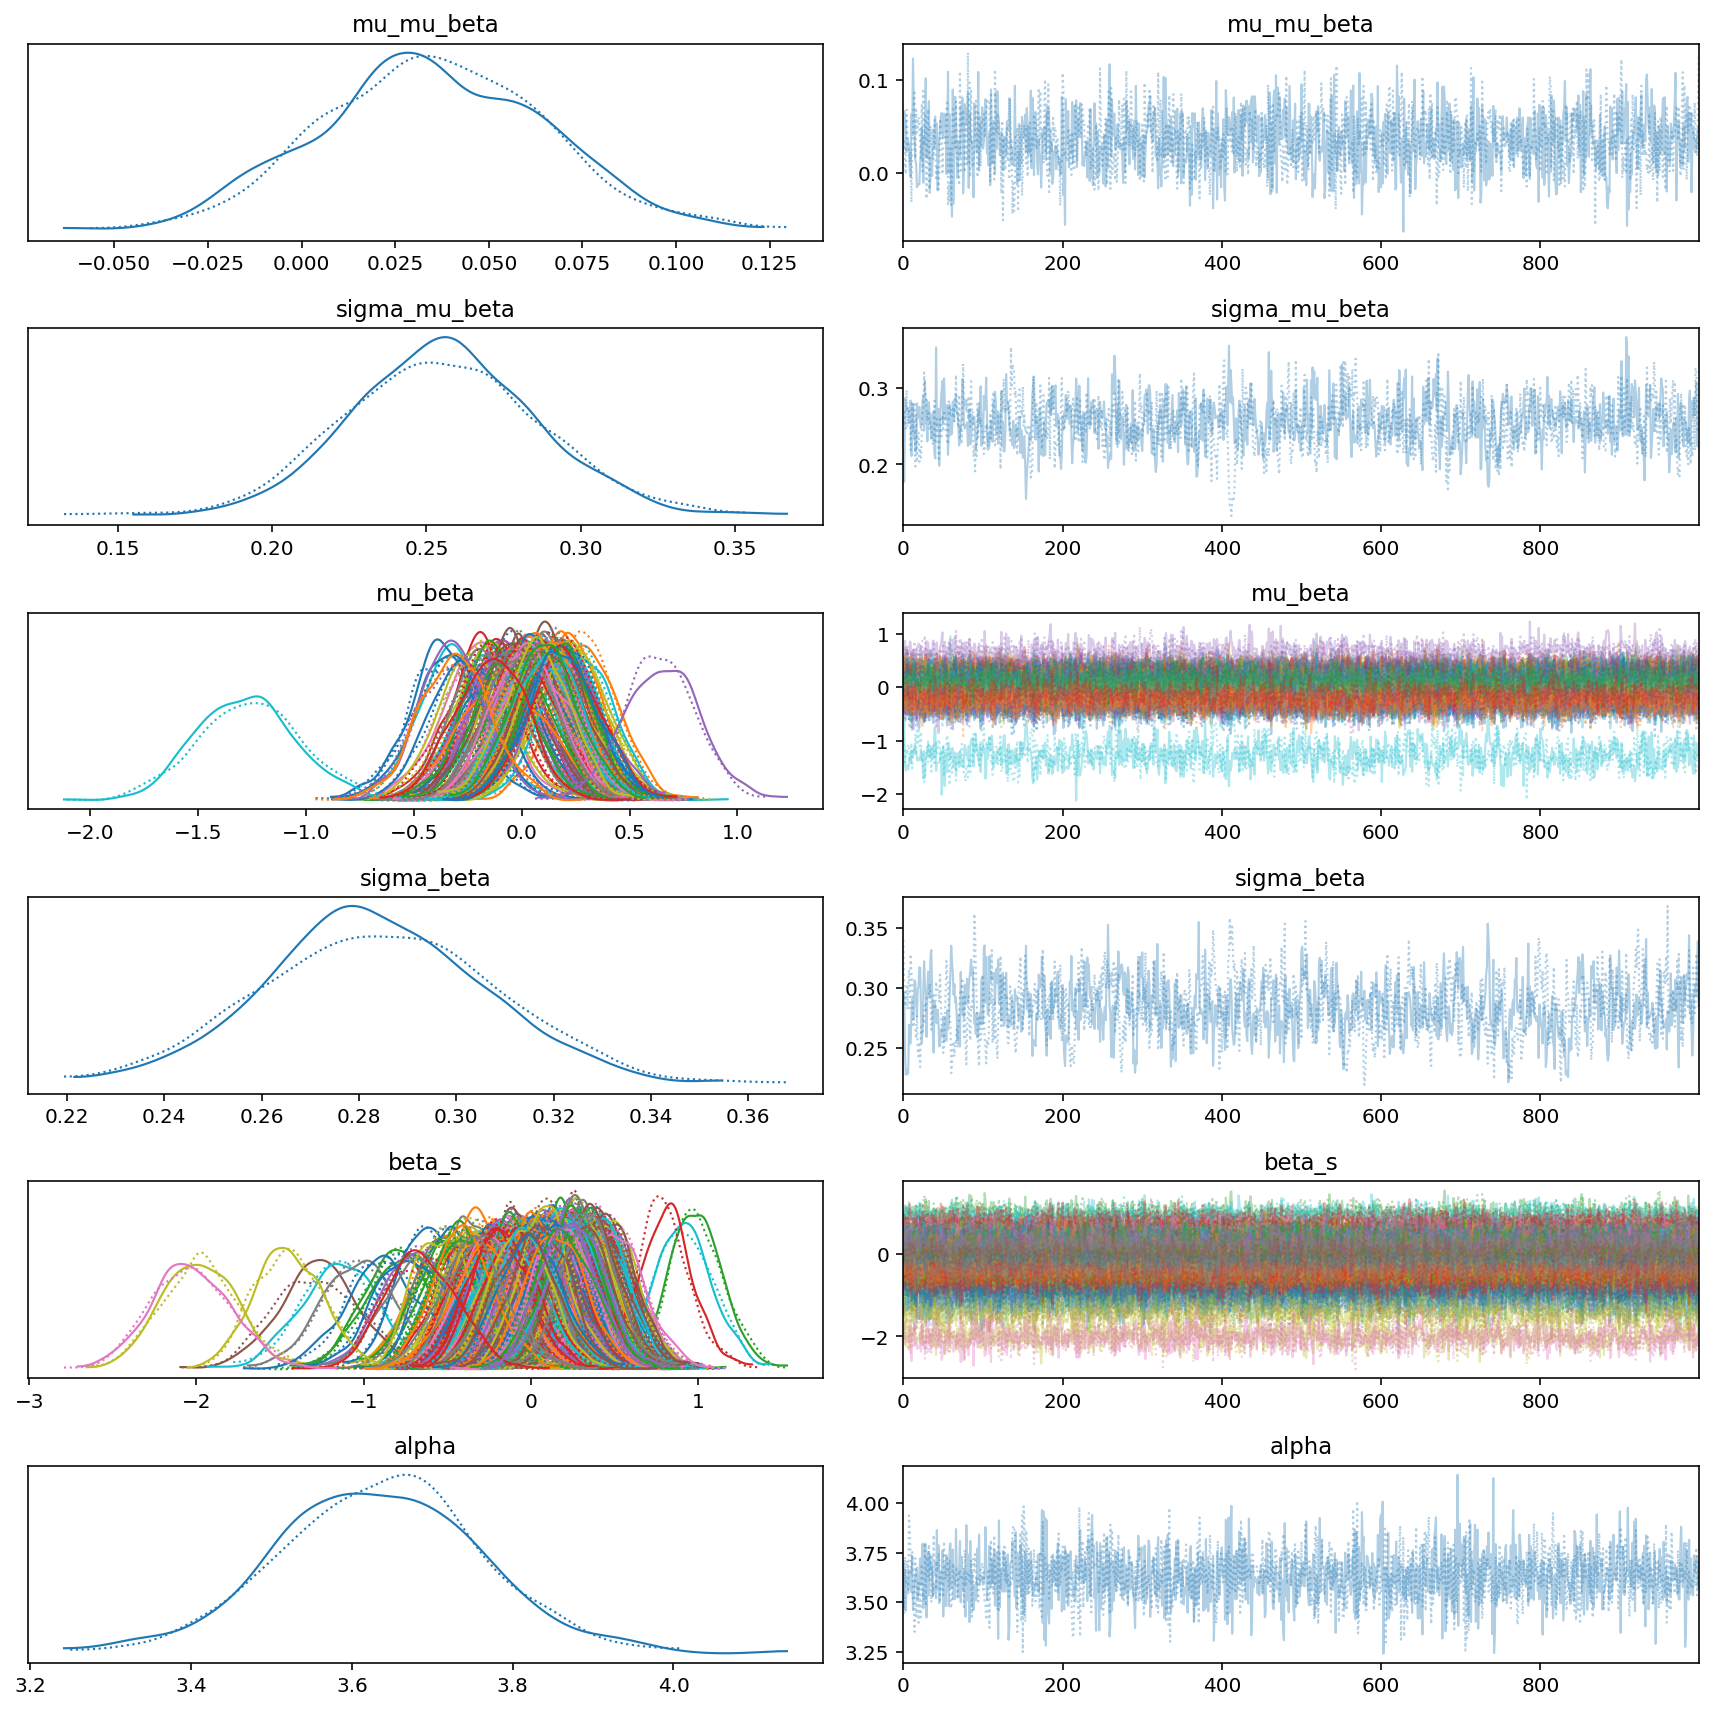

In [10]:
az.plot_trace(stan_trace, var_names=az_var_names, filter_vars="regex")
plt.tight_layout();

### PyMC3 MCMC

In [11]:
pymc_trace_pm = PosteriorManager("hierarchical-nb_PYMC3_MCMC", models_dir())

In [12]:
assert pymc_trace_pm.posterior_cache_exists, "PyMC3 MCMC cache not found."
pymc_trace = pymc_trace_pm.get()
pymc_trace

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/arviz/utils.py:129: UserWarning: Items starting with ~: ['log_lik', 'y_hat'] have not been found and will be ignored


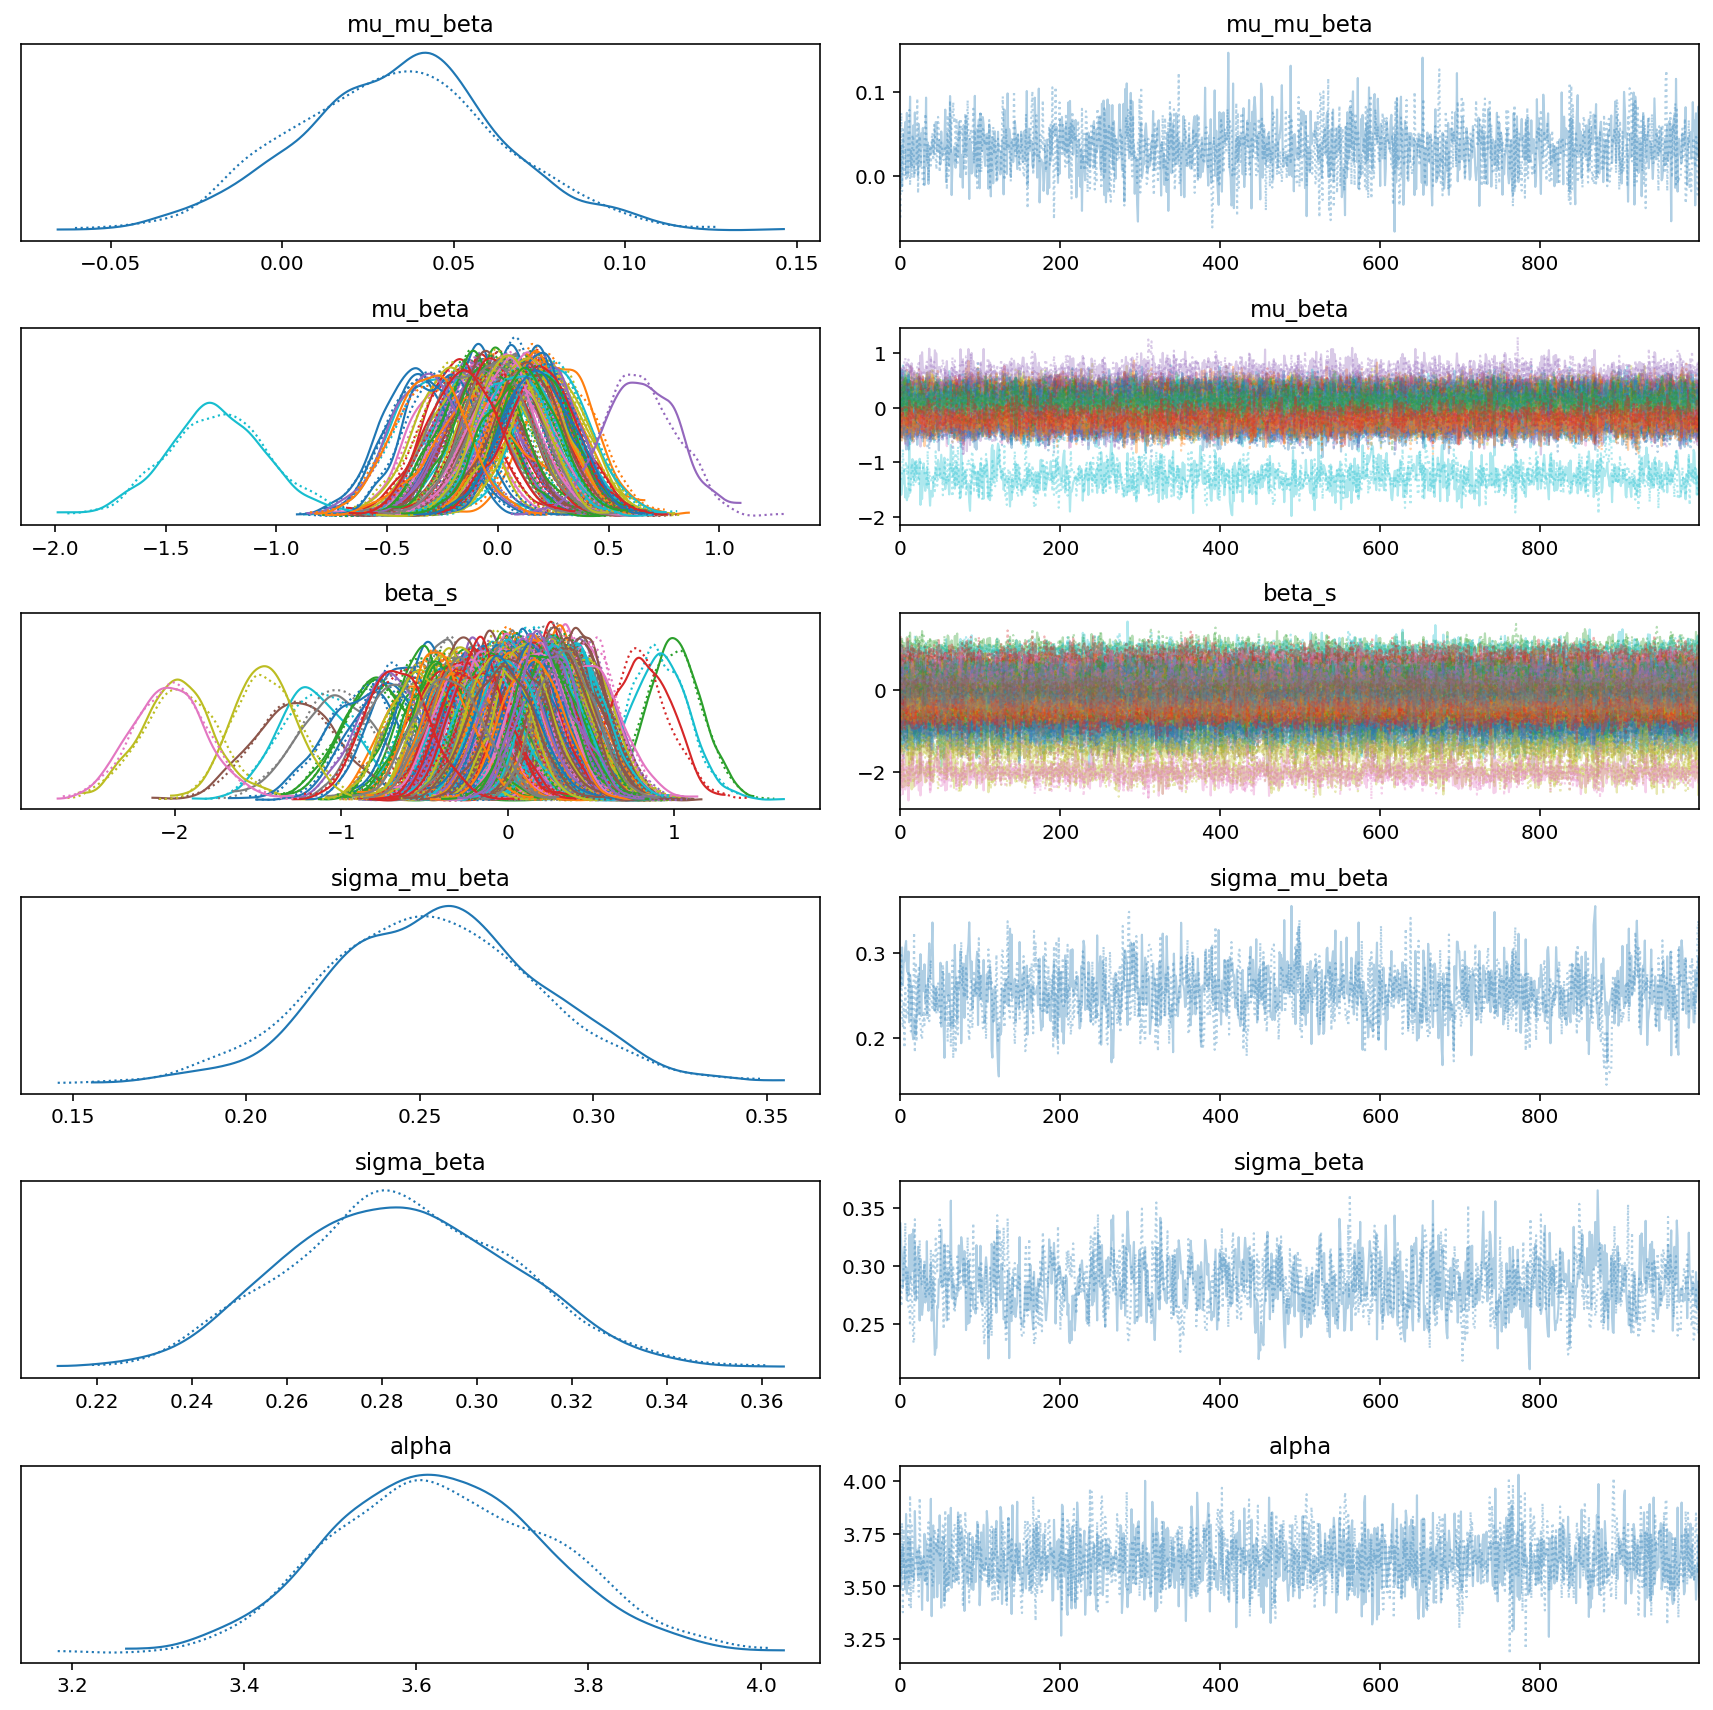

In [13]:
az.plot_trace(pymc_trace, var_names=az_var_names, filter_vars="regex")
plt.tight_layout();

### Comparison

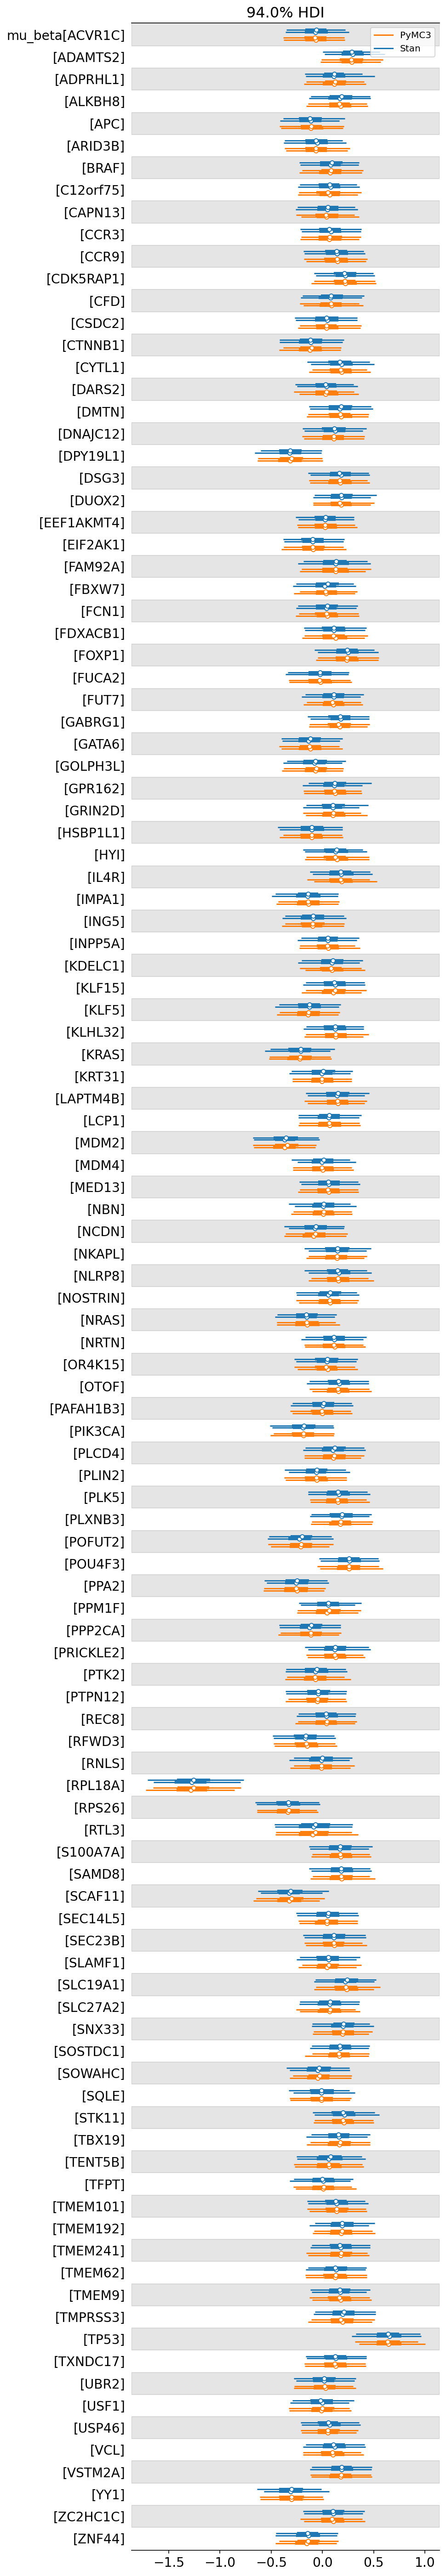

In [14]:
az.plot_forest(
    [stan_trace, pymc_trace], model_names=["Stan", "PyMC3"], var_names="mu_beta"
);

---

In [15]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 1.04 minutes


In [16]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-01-20

Python implementation: CPython
Python version       : 3.9.9
IPython version      : 8.0.0

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.2.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac

Git branch: nb-model

nest_asyncio: 1.5.4
arviz       : 0.11.4
numpy       : 1.22.0
matplotlib  : 3.5.1
seaborn     : 0.11.2
pymc3       : 3.11.4
plotnine    : 0.8.0
pandas      : 1.3.5

